In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/ETCCDI 실습(231017)'

/content/drive/My Drive/ETCCDI 실습(231017)


In [ ]:
import os
print(os.getcwd()b)

/content/drive/MyDrive/ETCCDI 실습(231017)


In [ ]:
path = './data/asos003_SQM_ACCESS-CM2_ssp126.csv'

In [ ]:
columns = ['YR','MM','DD','PCP','TMAX','TMIN']
daterange=('2011', '2100')
# nan values( if 1, then nan values will drop, if 0, then nan values will be replaced by backward fill or forward fill, if -1, program will stop)
nan_set=1
# RNN파라미터
user_defined_precipitation_threshold=10
df = pd.read_csv(path)
df = df[columns]

In [ ]:
df

,YR,MM,DD,PCP,TMAX,TMIN
0,2011,1,1,1.995873,0.284432,-10.967856
1,2011,1,2,0.000000,-4.815506,-13.668912
2,2011,1,3,0.000000,-1.222389,-13.255397
3,2011,1,4,0.000000,1.970950,-7.434089
4,2011,1,5,2.000000,2.013786,-15.333505
...,...,...,...,...,...,...
32867,2100,12,27,0.000000,-3.295329,-9.993720
32868,2100,12,28,0.000000,-3.396040,-10.083511
32869,2100,12,29,0.000000,-1.385300,-8.758787
32870,2100,12,30,0.000000,-0.619070,-7.658647


In [ ]:
##import data and qc
def qcEtccdi(df,daterange,nan_set):
    start_ymd=daterange[0]
    end_ymd=daterange[1]
    df['YMD']=pd.DatetimeIndex(df['YR'].astype(str)+'-'+df['MM'].astype(str)+'-'+df['DD'].astype(str))
    if start_ymd > end_ymd:
        print('startYMD should be earlier than endYMD')
        raise SystemExit(0)
    df=df[df['YMD'].between(pd.to_datetime(start_ymd), pd.to_datetime(end_ymd+'-12-31'))]
    if df.isnull().values.any():
        if nan_set==1:
            df.dropna(inplace=True)
            print('nan values have been dropped')
        elif nan_set==0:
            df.fillna(method='bfill', inplace=True)
            print('nan values have been replaced by backward fill and forward fill')
        elif nan_set==-1:
            print('There are nan values in the data, please check the data')
    df.index=pd.to_datetime(df['YMD'])
    df['JULYAN']=df.index.dayofyear
    return df

df_qc=qcEtccdi(df,daterange,nan_set)
df = df_qc.copy()

In [ ]:
PRCPTOT=df.groupby(df['YMD'].dt.year)['PCP'].sum()
FD0=df.groupby(df['YMD'].dt.year)['TMIN'].apply(lambda x: (x < 0).sum())
SU25=df.groupby(df['YMD'].dt.year)['TMAX'].apply(lambda x: (x > 25).sum())
ID0=df.groupby(df['YMD'].dt.year)['TMAX'].apply(lambda x: (x < 0).sum())
TR20=df.groupby(df['YMD'].dt.year)['TMIN'].apply(lambda x: (x > 20).sum())
R10=df.groupby(df['YMD'].dt.year)['PCP'].apply(lambda x: (x > 10).sum())
R20=df.groupby(df['YMD'].dt.year)['PCP'].apply(lambda x: (x > 20).sum())
RNN=df.groupby(df['YMD'].dt.year)['PCP'].apply(lambda x: (x < user_defined_precipitation_threshold).sum())
CDD=df.groupby(df['YMD'].dt.year)['PCP'].apply(lambda x: (x < 1).astype(int).groupby((x >= 1).astype(int).cumsum()).cumsum().max())
CWD=df.groupby(df['YMD'].dt.year)['PCP'].apply(lambda x: (x >= 1).astype(int).groupby((x < 1).astype(int).cumsum()).cumsum().max())
SDII=df.groupby(df['YMD'].dt.year)['PCP'].sum() / (df.groupby(df['YMD'].dt.year)['PCP'].apply(lambda x: (x > 1).sum()))

TXX=df.groupby([df['YR'],df['MM']])['TMAX'].max()
TNN=df.groupby([df['YR'],df['MM']])['TMIN'].min()
TXN=df.groupby([df['YR'],df['MM']])['TMAX'].min()
TNX=df.groupby([df['YR'],df['MM']])['TMIN'].max()
DTR=df.groupby([df['YR'],df['MM']])['TMAX'].mean()-df.groupby([df['YR'],df['MM']])['TMIN'].mean()
RX1day=df.groupby([df['YR'],df['MM']])['PCP'].max()
RX5day=df.groupby([df['YR'], df['MM']])['PCP'].rolling(5).sum().max(level=[0,1])

<ipython-input-13-410b52477e05>:19: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  RX5day=df.groupby([df['YR'], df['MM']])['PCP'].rolling(5).sum().max(level=[0,1])


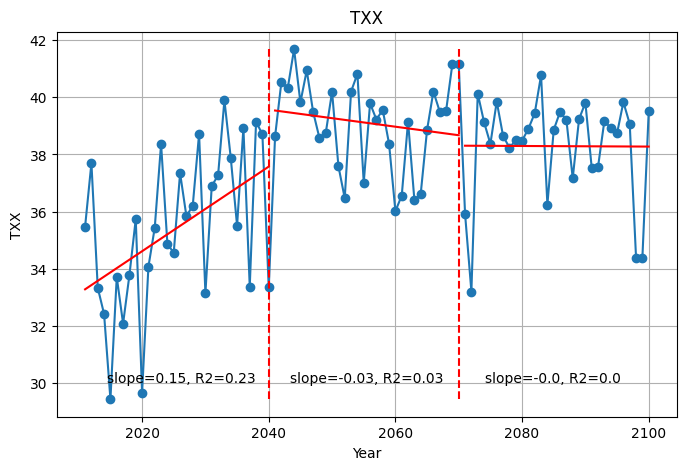

In [ ]:
plt.figure(figsize=(8,5))
plt.grid()

ind=TXX.groupby(TXX.index.get_level_values(0)).max().index
val=TXX.groupby(TXX.index.get_level_values(0)).max().values

plt.plot(ind,val,'-o')
plt.title('TXX')
plt.xlabel('Year')
plt.ylabel('TXX')

plt.vlines(x=2040, ymin=val.min(), ymax=val.max(), linestyles='dashed', color='r')
plt.vlines(x=2070, ymin=val.min(), ymax=val.max(), linestyles='dashed', color='r')


lr_model_F1=LR()
lr_model_F2=LR()
lr_model_F3=LR()

lr_model_F1.fit(ind.values.reshape(-1,1)[:30], val[:30])
lr_model_F2.fit(ind.values.reshape(-1,1)[30:60], val[30:60])
lr_model_F3.fit(ind.values.reshape(-1,1)[60:], val[60:])

plt.plot(ind[:30],lr_model_F1.predict(ind.values.reshape(-1,1)[:30]), color='r')
plt.plot(ind[30:60],lr_model_F2.predict(ind.values.reshape(-1,1)[30:60]), color='r')
plt.plot(ind[60:],lr_model_F3.predict(ind.values.reshape(-1,1)[60:]), color='r')

plt.text(
    0.2, 0.1,
    f'slope={round(lr_model_F1.coef_[0], 2)}, R2={round(lr_model_F1.score(ind.values.reshape(-1, 1)[:30], val[:30]), 2)}',
    fontdict={'ha': 'center', 'va': 'center'},
    transform=plt.gca().transAxes
)

plt.text(
    0.5, 0.1,
    f'slope={round(lr_model_F2.coef_[0], 2)}, R2={round(lr_model_F2.score(ind.values.reshape(-1, 1)[30:60], val[30:60]), 2)}',
    fontdict={'ha': 'center', 'va': 'center'},
    transform=plt.gca().transAxes
)


plt.text(
    0.8, 0.1,
    f'slope={round(lr_model_F3.coef_[0], 2)}, R2={round(lr_model_F3.score(ind.values.reshape(-1, 1)[60:], val[60:]), 2)}',
    fontdict={'ha': 'center', 'va': 'center'},
    transform=plt.gca().transAxes
)

plt.show()

In [ ]:
featue1=[PRCPTOT[:30].mean(),FD0[:30].mean(),SU25[:30].mean(),ID0[:30].mean(),TR20[:30].mean(),R10[:30].mean(),R20[:30].mean(),RNN[:30].mean(),CDD[:30].mean(),CWD[:30].mean(),SDII[:30].mean(),TXX[:30].mean(),TNN[:30].mean(),TXN[:30].mean(),TNX[:30].mean(),DTR[:30].mean(),RX1day[:30].mean(),RX5day[:30].mean()]
featue2=[PRCPTOT[30:60].mean(),FD0[30:60].mean(),SU25[30:60].mean(),ID0[30:60].mean(),TR20[30:60].mean(),R10[30:60].mean(),R20[30:60].mean(),RNN[30:60].mean(),CDD[30:60].mean(),CWD[30:60].mean(),SDII[30:60].mean(),TXX[30:60].mean(),TNN[30:60].mean(),TXN[30:60].mean(),TNX[30:60].mean(),DTR[30:60].mean(),RX1day[30:60].mean(),RX5day[30:60].mean()]
featue3=[PRCPTOT[60:].mean(),FD0[60:].mean(),SU25[60:].mean(),ID0[60:].mean(),TR20[60:].mean(),R10[60:].mean(),R20[60:].mean(),RNN[60:].mean(),CDD[60:].mean(),CWD[60:].mean(),SDII[60:].mean(),TXX[60:].mean(),TNN[60:].mean(),TXN[60:].mean(),TNX[60:].mean(),DTR[60:].mean(),RX1day[60:].mean(),RX5day[60:].mean()]
displaydf=pd.DataFrame([featue1,featue2,featue3],columns=['PRCPTOT','FD0','SU25','ID0','TR20','R10','R20','RNN','CDD','CWD','SDII','TXX','TNN','TXN','TNX','DTR','RX1day','RX5day'],index=['Future1','Future2','Future3']).T
displaydf.apply(lambda x: round(x,2))

,Future1,Future2,Future3
PRCPTOT,822.87,915.82,906.73
FD0,130.40,116.50,112.93
SU25,63.60,95.10,100.97
ID0,38.30,31.43,30.00
TR20,40.37,64.97,66.40
R10,19.77,21.83,21.43
R20,11.13,13.33,12.73
RNN,345.47,343.13,343.70
CDD,43.63,42.47,46.77
CWD,6.07,6.57,7.67
